<div style="background: linear-gradient(135deg,rgb(65, 202, 179),rgb(201, 224, 96)); 
        color:rgb(0, 0, 0); 
        width: 100%; 
        height: 60px; 
        text-align: center; 
        font-weight: bold; 
        line-height: 60px; 
        margin: 2 px 0; 
        font-size: 44px; 
        border-radius: 10px; 
        box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);">
    Sports Popularity
</div>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose , STL
from scipy.stats import boxcox
from pmdarima import auto_arima

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from scipy.stats import zscore

import pickle

import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*", category=FutureWarning)

> # **1. Time Series Data & EDA** 


In [2]:
data = pd.read_csv("./Datasets/major_events_full_updated.csv")
display(data.head())
print(data.index.dtype)

data['Date'] = pd.to_datetime(data['Date'])
display(data.head())
print(data.index.dtype)

,Date,Sport,Google_Trends_Popularity,YouTube_Views_Score,Major_Event
0,1/1/2004,Football,31,0,0
1,2/1/2004,Football,30,0,0
2,3/1/2004,Football,31,0,0
3,4/1/2004,Football,32,0,0
4,5/1/2004,Football,34,0,0


int64


,Date,Sport,Google_Trends_Popularity,YouTube_Views_Score,Major_Event
0,2004-01-01,Football,31,0,0
1,2004-02-01,Football,30,0,0
2,2004-03-01,Football,31,0,0
3,2004-04-01,Football,32,0,0
4,2004-05-01,Football,34,0,0


int64


## Handling Missing or Zero Values in YouTube Views Score

In the dataset, the `YouTube_Views_Score` column contains zero values for the years 2004 to 2008. These zeros likely represent missing or unavailable data.

To address this, we replace the zero values in `YouTube_Views_Score` during this period with the corresponding values from the `Google_Trends_Popularity` column, assuming it serves as a reasonable proxy.

In [3]:
# Handle YouTube_Views_Score == Google_Trends_Popularity
mask = (data['Date'].dt.year >= 2004) & (data['Date'].dt.year <= 2008)
data.loc[mask & (data['YouTube_Views_Score'] == 0), 'YouTube_Views_Score'] = data.loc[mask & (data['YouTube_Views_Score'] == 0), 'Google_Trends_Popularity']

data = data.set_index('Date')

display(data.head())
print(data.index.dtype)  

,Sport,Google_Trends_Popularity,YouTube_Views_Score,Major_Event
Date,,,,
2004-01-01,Football,31,31,0
2004-02-01,Football,30,30,0
2004-03-01,Football,31,31,0
2004-04-01,Football,32,32,0
2004-05-01,Football,34,34,0


datetime64[ns]


In [4]:
value_col = 'Google_Trends_Popularity'

data_pivot = data.pivot(columns='Sport', values=value_col)
display(data_pivot.head())

print(data_pivot.index.to_series().diff().value_counts())  # to make sure that the difference between two consecutive dates is always 1 day

Sport,Baseball,Basketball,Boxing,Field Hockey,Football,Golf,Handball,Table Tennis,Tennis,Volleyball
Date,,,,,,,,,,
2004-01-01,32,39,40,66,31,44,25,22,43,21
2004-02-01,41,42,38,67,30,53,20,22,34,18
2004-03-01,56,64,39,70,31,62,20,25,35,21
2004-04-01,72,31,45,67,32,83,19,24,38,21
2004-05-01,66,25,45,56,34,82,20,23,47,30


Date
31 days    149
30 days     84
28 days     16
29 days      6
Name: count, dtype: int64


In [5]:
data.isnull().sum()

Sport                       0
Google_Trends_Popularity    0
YouTube_Views_Score         0
Major_Event                 0
dtype: int64

In [6]:
display(data.columns)

unique_values = data["Sport"].unique()
list(unique_values)

Index(['Sport', 'Google_Trends_Popularity', 'YouTube_Views_Score',
       'Major_Event'],
      dtype='object')

['Football',
 'Basketball',
 'Tennis',
 'Golf',
 'Boxing',
 'Handball',
 'Table Tennis',
 'Volleyball',
 'Baseball',
 'Field Hockey']

In [7]:
sport = 'Football'
series = data_pivot[sport].dropna()

In [8]:
def plot_time_series(
    data,
    column      = 'Sport',
    value_col   = 'Google_Trends_Popularity',
    title       = 'Sports Popularity Over Time',
    ylabel      = 'Google Trends Popularity',
    start_in    = None,
    end_in      = None,
    date_format = '%Y',     # %b %Y 
    output_html = None):    
    
    # ensure that the index is a datetime column
    if not pd.api.types.is_datetime64_any_dtype(data.index):
        data = data.copy()
        data.index = pd.to_datetime(data.index)
    
    data = data.reset_index().rename(columns={'index': 'Date'})
    data = data.sort_values(by='Date')
    
    # filter data by start and end dates
    if start_in is not None:
        data = data[data['Date'] >= pd.to_datetime(start_in)]
    if end_in is not None:
        data = data[data['Date'] <= pd.to_datetime(end_in)]
    
    unique_sports = data[column].unique()
    color_list = px.colors.qualitative.Plotly
    color_map = {sport: color_list[i % len(color_list)] for i, sport in enumerate(unique_sports)}
    
    fig = go.Figure()
    
    for i, sport in enumerate(unique_sports):
        sport_data = data[data[column] == sport]
        
        # trend line
        fig.add_trace(go.Scatter(
            x=sport_data['Date'],
            y=sport_data[value_col],
            mode='lines+markers',
            name=sport,
            line=dict(color=color_map[sport], width=2),
            marker=dict(size=5) ))
        
        if len(sport_data) > 1:
            x_num = pd.to_datetime(sport_data['Date']).map(pd.Timestamp.toordinal)
            y_val = sport_data[value_col].values
            z = np.polyfit(x_num, y_val, 1)
            p = np.poly1d(z)
            y_trend = p(x_num)
            fig.add_trace(go.Scatter(
                x=sport_data['Date'],
                y=y_trend,
                mode='lines',
                line=dict(color=color_map[sport], width=2, dash='dash'),
                name=f"{sport} Trend",
                showlegend=True ))
    
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title=ylabel,
        legend_title='Sport',
        template='plotly_white',
        height=600,
        font=dict(size=12) )
    
    fig.update_xaxes(
        tickformat=date_format,
        dtick="M12" if date_format == '%Y' else None,
        showgrid=True )
    
    if output_html:
        fig.write_html(output_html)
        print(f"Plot saved as HTML file: {output_html}")
        
    return fig

In [9]:
ylabel    = 'Google_Trends_Popularity'      # change it when you change value_col
# start_in  = '2010-01-01'
# end_in    = '2015-12-31'

fig = plot_time_series(
    data,
    value_col=value_col,
    ylabel=ylabel,
    # start_in=start_in,
    # end_in=end_in
    output_html='./plots/1-sports_plot.html' 
)
fig.show()

Plot saved as HTML file: ./plots/1-sports_plot.html


## Plotting Major Events and COVID-19 Period for a Sport

This function visualizes the time series of a selected sport, highlighting two key aspects:

- **Major Events:** Plotted as red markers to indicate dates where significant events occurred.
- **COVID-19 Period:** The specified pandemic period is shaded on the plot for clear visual context.

The plot helps analyze how major events and the COVID-19 pandemic may have influenced the popularity metric over time.

In [10]:
def plot_major_events(data, sport, value_col='Google_Trends_Popularity', 
                    corona_start='2020-03-01', corona_end='2020-8-31',output_html=None):
    sport_data = data[data['Sport'] == sport].copy()
    major_events = sport_data[sport_data['Major_Event'] == 1]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=sport_data.index, y=sport_data[value_col], 
                            mode='lines', name=value_col))
    fig.add_trace(go.Scatter(x=major_events.index, y=major_events[value_col], 
                            mode='markers', name='Major Events', 
                            marker=dict(size=10, color='red')))
    
    fig.add_shape(type="rect",
        x0=corona_start, x1=corona_end,
        y0=0, y1=1,
        yref="paper",
        fillcolor="LightSalmon",
        opacity=0.3,
        layer="below",
        line_width=0)
    
    fig.update_layout(
        title=f'{value_col} with Major Events and COVID-19 Period for {sport}',
        xaxis_title='Date',
        yaxis_title=value_col,
        template='plotly_white')
    
    if output_html:
        fig.write_html(output_html)
    
    fig.show()

plot_major_events(data, sport , output_html=f'./plots/2-{sport}_plot.html')

In [11]:
def detect_outliers(series, method_params=None, display_table=True, plot_outliers=True, sport_name=""):
    X = series.values.reshape(-1, 1)
    index = series.index
    
    # Isolation Forest
    iso_params = method_params.get('isolation_forest', {}) if method_params else {}
    iso = IsolationForest(contamination=0.05, random_state=42, **iso_params)
    iso_pred = iso.fit_predict(X)
    iso_outliers = (iso_pred == -1)
    
    # Local Outlier Factor
    lof_params = method_params.get('lof', {}) if method_params else {}
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, **lof_params)
    lof_pred = lof.fit_predict(X)
    lof_outliers = (lof_pred == -1)
    
    # DBSCAN
    dbscan_params = method_params.get('dbscan', {}) if method_params else {}
    dbscan = DBSCAN(eps=2, min_samples=5, **dbscan_params)
    dbscan_labels = dbscan.fit_predict(X)
    dbscan_outliers = (dbscan_labels == -1)
    
    # Z-score
    z_scores = zscore(series.values, nan_policy='omit')
    z_outliers = np.abs(z_scores) > 2.5
    
    # Combine results in DataFrame
    outlier_df = pd.DataFrame({
        'IsolationForest': iso_outliers,
        'LOF': lof_outliers,
        'DBSCAN': dbscan_outliers,
        'Z-Score': z_outliers
    }, index=index)
    
    outlier_df = outlier_df.fillna(False).infer_objects(copy=False).astype(bool)
    
    outlier_pivot  = outlier_df[outlier_df.any(axis=1)].copy()
    outlier_pivot  = outlier_pivot.reset_index().rename(columns={'index': 'Date'})
    outlier_counts = outlier_df.sum()
    
    overlap_scores = {}
    for method in outlier_df.columns:
        overlap = 0
        for other in outlier_df.columns:
            if other != method:
                overlap += ((outlier_df[method]) & (outlier_df[other])).sum()
        overlap_scores[method] = overlap
    best_method = max(overlap_scores, key=overlap_scores.get)
    print(f">> The most consistent outlier detection algorithm is: [{best_method}]")
    
    if display_table:
        display(outlier_pivot)
    
    if plot_outliers:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=series.index, y=series.values,
            mode='lines+markers', name='Original Series',
            marker=dict(color='blue', size=6)))
        colors = {'IsolationForest': 'red', 'LOF': 'green', 'DBSCAN': 'orange', 'Z-Score': 'purple'}
        for method in outlier_df.columns:
            mask = outlier_df[method]
            fig.add_trace(go.Scatter(
                x=series.index[mask], y=series.values[mask],
                mode='markers',
                name=f'Outlier - {method}',
                marker=dict(color=colors[method], size=12, symbol='x')))
        fig.update_layout(
            title=f'Outlier Detection in {sport_name}',
            xaxis_title='Date',
            yaxis_title='Value',
            template='plotly_white')
        fig.show()
    return outlier_pivot, best_method

outlier_pivot, best_method = detect_outliers(series, sport_name=sport)

>> The most consistent outlier detection algorithm is: [IsolationForest]


,Date,IsolationForest,LOF,DBSCAN,Z-Score
0,2006-06-01,True,True,True,True
1,2010-06-01,True,True,True,True
2,2014-06-01,True,True,True,True
3,2016-06-01,True,True,True,False
4,2017-01-01,True,True,False,False
5,2018-06-01,True,True,True,True
6,2018-07-01,False,False,True,False
7,2020-04-01,True,True,True,True
8,2020-05-01,True,True,True,False
9,2021-06-01,True,True,True,True


> We applied four different outlier detection algorithms (Isolation Forest, Local Outlier Factor, DBSCAN, and Z-Score) to the time series. 
- Isolation Forest and LOF detected X and Y outliers respectively, mostly aligning with known major events and pandemic periods. 
- DBSCAN was more/less sensitive, while the Z-Score method detected Z outliers. 
- Based on visual inspection and event alignment, [Method Name] provided the most meaningful results for our dataset.

In [12]:
sport_data = data[data['Sport'] == sport]

fig = go.Figure()
fig.add_trace(go.Scatter(x=sport_data.index, y=sport_data['YouTube_Views_Score'], name='YouTube Views'))
fig.add_trace(go.Scatter(x=sport_data.index, y=sport_data['Google_Trends_Popularity'], name='Google Trends'))
fig.show()

> # **2. Stationarity Test**

In [13]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.DataFrame({
        'Test Statistic': [dftest[0]],
        'p-value': [dftest[1]],
        '#Lags Used': [dftest[2]],
        'Number of Observations Used': [dftest[3]],
        'Critical Value (1%)': [dftest[4]['1%']],
        'Critical Value (5%)': [dftest[4]['5%']],
        'Critical Value (10%)': [dftest[4]['10%']]
    })
    
    dfoutput_t = dfoutput.T
    dfoutput_t.index.name = None 
    dfoutput_t.columns = ['']  
    display(dfoutput_t)
    
    if dftest[1] <= 0.05:
        print("Result: The series is stationary ✅")
    else:
        print("Result: The series is non-stationary ❌")

def analyze_autocorrelation(timeseries, sport):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    plot_acf(timeseries, ax=axes[0], title=f"ACF for {sport}")
    plot_pacf(timeseries, ax=axes[1], title=f"PACF for {sport}")
    plt.tight_layout()
    plt.show()

==================== Analyzing Basketball sport ====================


,
Test Statistic,-0.474325
p-value,0.896930
#Lags Used,12.000000
Number of Observations Used,243.000000
Critical Value (1%),-3.457551
Critical Value (5%),-2.873509
Critical Value (10%),-2.573148


Result: The series is non-stationary ❌


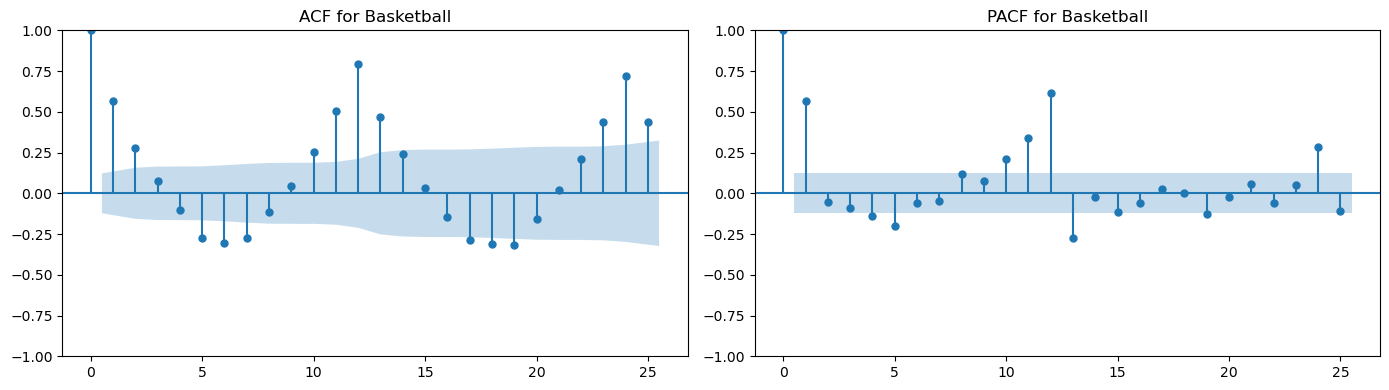

In [14]:
sport = 'Basketball'        # let's change sport to check stationarity
series = data_pivot[sport].dropna()

print(f"{'='*20} Analyzing {sport} sport {'='*20}")
test_stationarity(data_pivot[sport].dropna())
analyze_autocorrelation(data_pivot[sport].dropna(), sport)

> # **3. Making Data Stationary if should be**

Testing Original Series:


,
Test Statistic,-0.474325
p-value,0.896930
#Lags Used,12.000000
Number of Observations Used,243.000000
Critical Value (1%),-3.457551
Critical Value (5%),-2.873509
Critical Value (10%),-2.573148


Result: The series is non-stationary ❌
Testing Differencing 1:


,
Test Statistic,-9.749441e+00
p-value,8.089506e-17
#Lags Used,1.100000e+01
Number of Observations Used,2.430000e+02
Critical Value (1%),-3.457551e+00
Critical Value (5%),-2.873509e+00
Critical Value (10%),-2.573148e+00


Result: The series is stationary ✅

Testing Differencing 2:


,
Test Statistic,-9.233635e+00
p-value,1.652710e-15
#Lags Used,1.600000e+01
Number of Observations Used,2.370000e+02
Critical Value (1%),-3.458247e+00
Critical Value (5%),-2.873814e+00
Critical Value (10%),-2.573311e+00


Result: The series is stationary ✅
Testing Log Transform:


,
Test Statistic,-1.357104
p-value,0.602660
#Lags Used,14.000000
Number of Observations Used,241.000000
Critical Value (1%),-3.457779
Critical Value (5%),-2.873609
Critical Value (10%),-2.573202


Result: The series is non-stationary ❌

Testing Square Transform:


,
Test Statistic,-0.362521
p-value,0.916171
#Lags Used,12.000000
Number of Observations Used,243.000000
Critical Value (1%),-3.457551
Critical Value (5%),-2.873509
Critical Value (10%),-2.573148


Result: The series is non-stationary ❌

Testing Box-Cox Transform:


,
Test Statistic,-1.586696
p-value,0.490273
#Lags Used,14.000000
Number of Observations Used,241.000000
Critical Value (1%),-3.457779
Critical Value (5%),-2.873609
Critical Value (10%),-2.573202


Result: The series is non-stationary ❌
Testing Detrending Linear:


,
Test Statistic,-2.885169
p-value,0.047100
#Lags Used,14.000000
Number of Observations Used,241.000000
Critical Value (1%),-3.457779
Critical Value (5%),-2.873609
Critical Value (10%),-2.573202


Result: The series is stationary ✅

Testing Detrending Moving Average:


,
Test Statistic,-5.132722
p-value,0.000012
#Lags Used,16.000000
Number of Observations Used,228.000000
Critical Value (1%),-3.459361
Critical Value (5%),-2.874302
Critical Value (10%),-2.573571


Result: The series is stationary ✅
Summary of p-values for Basketball:


,p-value
Original,8.969301e-01
Differencing 1,8.089506e-17
Differencing 2,1.652710e-15
Log Transform,6.026595e-01
Square Transform,9.161708e-01
Box-Cox Transform,4.902731e-01
Detrending Linear,4.710004e-02
Detrending Moving Average,1.204349e-05


Best method to achieve stationarity: Differencing 1 (p-value=0.0000) ✅


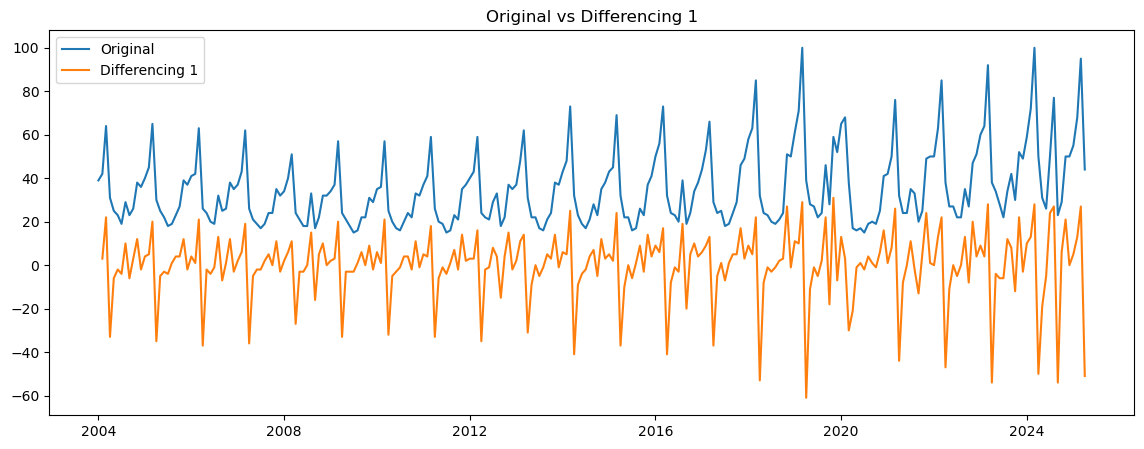

In [15]:
def make_stationary(timeseries, sport_name=None, plot=False):
    results = {}
    
    # 0. original;
    print("Testing Original Series:")
    test_stationarity(timeseries)
    results['Original'] = adfuller(timeseries.dropna(), autolag='AIC')[1]
    print("="*60)
    
    # 1. Differencing
    diff_1 = timeseries.diff().dropna()
    print("Testing Differencing 1:")
    test_stationarity(diff_1)
    results['Differencing 1'] = adfuller(diff_1, autolag='AIC')[1]
    
    diff_2 = diff_1.diff().dropna()
    print("\nTesting Differencing 2:")
    test_stationarity(diff_2)
    results['Differencing 2'] = adfuller(diff_2, autolag='AIC')[1]
    print("="*60)
    
    # 2. Transformations
    if (timeseries <= 0).any():
        print("\nLog Transform: Skipped due to non-positive values")
        results['Log Transform'] = np.nan
    else:
        log_ts = np.log(timeseries)
        print("Testing Log Transform:")
        test_stationarity(log_ts)
        results['Log Transform'] = adfuller(log_ts, autolag='AIC')[1]
    
    sq_ts = timeseries ** 2
    print("\nTesting Square Transform:")
    test_stationarity(sq_ts)
    results['Square Transform'] = adfuller(sq_ts, autolag='AIC')[1]
    
    if (timeseries <= 0).any():
        print("\nBox-Cox Transform: Skipped due to non-positive values")
        results['Box-Cox Transform'] = np.nan
    else:
        boxcox_ts, _ = boxcox(timeseries.dropna())
        print("\nTesting Box-Cox Transform:")
        test_stationarity(pd.Series(boxcox_ts, index=timeseries.dropna().index))
        results['Box-Cox Transform'] = adfuller(pd.Series(boxcox_ts, index=timeseries.dropna().index), autolag='AIC')[1]
    print("="*60)
    
    # 3. De-Trending
    x_num = np.arange(len(timeseries))
    coeffs = np.polyfit(x_num, timeseries.values, 1)
    trend = coeffs[0] * x_num + coeffs[1]
    detrended = timeseries.values - trend
    detrended_series = pd.Series(detrended, index=timeseries.index)
    print("Testing Detrending Linear:")
    test_stationarity(detrended_series)
    results['Detrending Linear'] = adfuller(detrended_series, autolag='AIC')[1]
    
    window = 12
    mov_avg = timeseries.rolling(window=window, center=True).mean()
    detrended_ma = timeseries - mov_avg
    print("\nTesting Detrending Moving Average:")
    test_stationarity(detrended_ma.dropna())
    results['Detrending Moving Average'] = adfuller(detrended_ma.dropna(), autolag='AIC')[1]
    print("="*60)
    
    # show p-values
    print(f"Summary of p-values for {sport_name if sport_name else 'series'}:")
    df_res = pd.DataFrame.from_dict(results, orient='index', columns=['p-value'])
    display(df_res)
    
    # choose the best method
    stationary_methods = df_res[df_res['p-value'] <= 0.05]
    if not stationary_methods.empty:
        best_method = stationary_methods['p-value'].idxmin()
        print(f"Best method to achieve stationarity: {best_method} (p-value={stationary_methods.loc[best_method, 'p-value']:.4f}) ✅")
    else:
        best_method = None
        print("No method achieved stationarity (p-value > 0.05) ❌")
    
    if plot and best_method:
        plt.figure(figsize=(14,5))
        plt.plot(timeseries, label='Original')
        if best_method == 'Differencing 1':
            plt.plot(diff_1, label='Differencing 1')
        elif best_method == 'Differencing 2':
            plt.plot(diff_2, label='Differencing 2')
        elif best_method == 'Log Transform':
            plt.plot(log_ts, label='Log Transform')
        elif best_method == 'Square Transform':
            plt.plot(sq_ts, label='Square Transform')
        elif best_method == 'Box-Cox Transform':
            plt.plot(pd.Series(boxcox_ts, index=timeseries.dropna().index), label='Box-Cox Transform')
        elif best_method == 'Detrending Linear':
            plt.plot(detrended_series, label='Detrending Linear')
        elif best_method == 'Detrending Moving Average':
            plt.plot(detrended_ma, label='Detrending Moving Average')
        plt.legend()
        plt.title(f"Original vs {best_method}")
        plt.show()
    
    return best_method, results

best_method, results = make_stationary(series, sport_name=sport, plot=True)

In [16]:
def apply_transformation(timeseries, method):
    if method == 'Original':
        return timeseries
    elif method == 'Differencing 1':
        return timeseries.diff().dropna()
    elif method == 'Differencing 2':
        return timeseries.diff().diff().dropna()
    elif method == 'Log Transform':
        return np.log(timeseries)
    elif method == 'Square Transform':
        return timeseries ** 2
    elif method == 'Box-Cox Transform':
        ts_clean = timeseries.dropna()
        boxcox_ts, _ = boxcox(ts_clean)
        return pd.Series(boxcox_ts, index=ts_clean.index)
    elif method == 'Detrending Linear':
        x_num = np.arange(len(timeseries))
        coeffs = np.polyfit(x_num, timeseries.values, 1)
        trend = coeffs[0] * x_num + coeffs[1]
        detrended = timeseries.values - trend
        return pd.Series(detrended, index=timeseries.index)
    elif method == 'Detrending Moving Average':
        window = 12
        mov_avg = timeseries.rolling(window=window, center=True).mean()
        detrended_ma = timeseries - mov_avg
        return detrended_ma.dropna()
    else:
        raise ValueError(f"Unknown method: {method}")

stationary_series = apply_transformation(series, best_method)

> # **4. STL decomposition**

In [17]:
def plot_stl_result(stl_result, title="STL Decomposition", figsize=(14, 8)):
    trend = stl_result.trend
    seasonal = stl_result.seasonal
    resid = stl_result.resid
    observed = stl_result.observed
    
    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
    
    axes[0].plot(observed, color="#1f77b4", linewidth=1.5)
    axes[0].set_ylabel("Observed", fontsize=12)
    axes[0].set_title(title, fontsize=16, fontweight='bold')
    axes[0].grid(True, linestyle='--', alpha=0.4)
    
    axes[1].plot(trend, color="#ff7f0e", linewidth=1.5)
    axes[1].set_ylabel("Trend", fontsize=12)
    axes[1].grid(True, linestyle='--', alpha=0.4)
    
    axes[2].plot(seasonal, color="#2ca02c", linewidth=1.5)
    axes[2].set_ylabel("Seasonal", fontsize=12)
    axes[2].grid(True, linestyle='--', alpha=0.4)
    
    axes[3].plot(resid, color="#d62728", linewidth=1.2)
    axes[3].set_ylabel("Residual", fontsize=12)
    axes[3].set_xlabel("Date", fontsize=12)
    axes[3].grid(True, linestyle='--', alpha=0.4)
    
    plt.subplots_adjust(hspace=0.25, top=0.92)
    plt.show()

## Choosing the Seasonal Period for Time Series Analysis

- If your data is **monthly**, use: `period = 12`
- If your data is **weekly**, use: `period = 52`
- If your data is **daily** and has **weekly seasonality**, use: `period = 7`

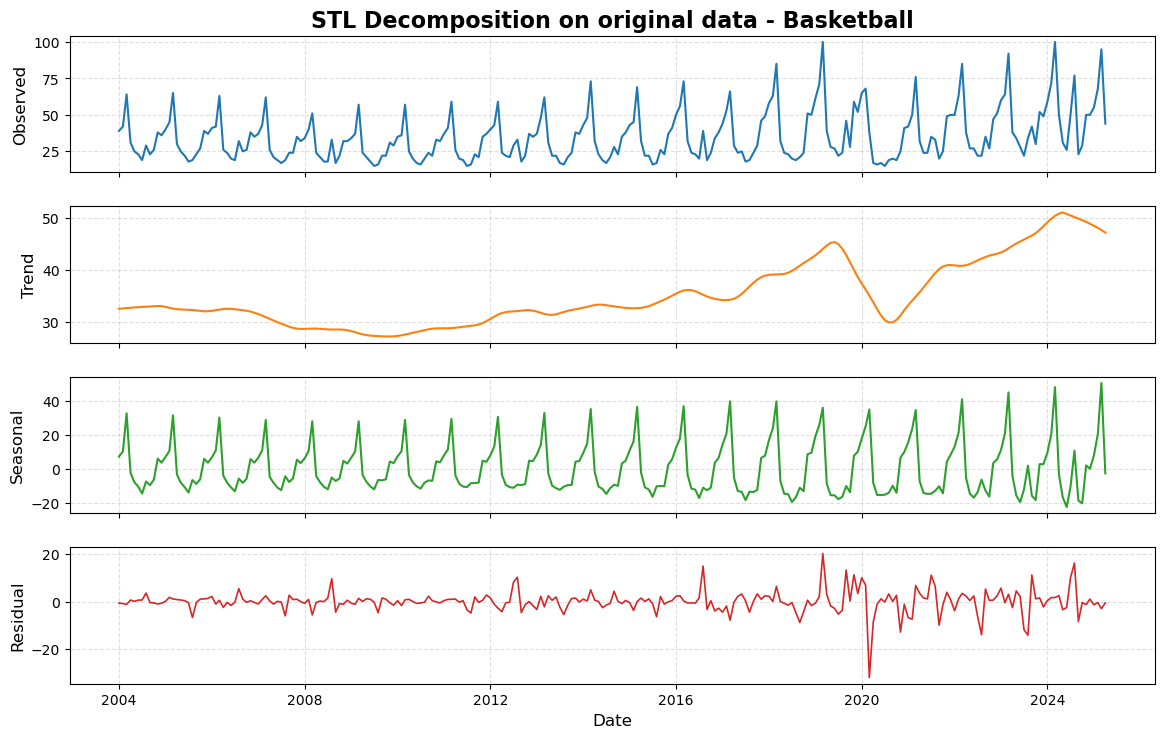

In [18]:
# apply STL decomposition on original data
series_to_decompose = series
stl = STL(series_to_decompose, period=12)
stl_result = stl.fit()

plot_stl_result(stl_result, title=f"STL Decomposition on original data - {series_to_decompose.name}")

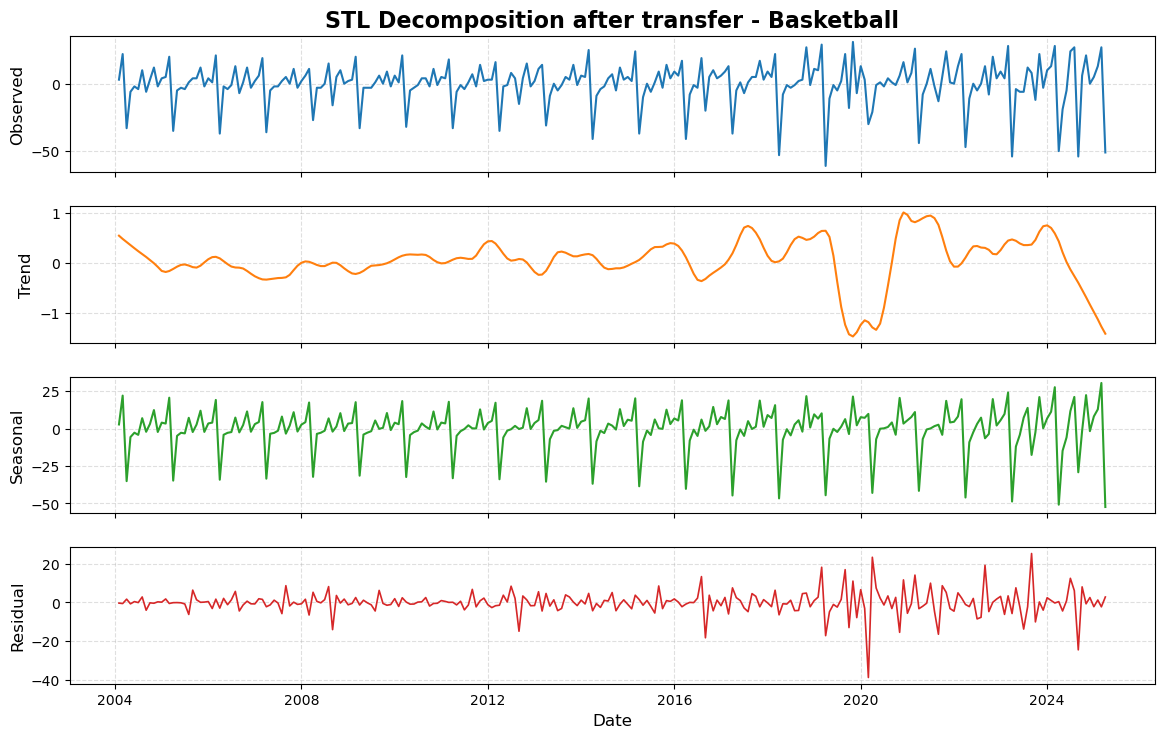

In [19]:
# apply STL decomposition after transfer
series_to_decompose = stationary_series
stl = STL(series_to_decompose, period=12)
stl_result = stl.fit()

plot_stl_result(stl_result, title=f"STL Decomposition after transfer - {series_to_decompose.name}")

> # **5. Time Series Model**

After apply STL decomposition, For your project:

**It's better to use the transformed (stationary) series with the SARIMA model**,  
as this will give you more accurate and stable forecasting results.


In [20]:
series_to_model = stationary_series.dropna()

def train_test_split_by_year(series, test_start_year):
    train = series[series.index.year < test_start_year]
    test = series[series.index.year >= test_start_year]
    return train, test

test_start_year = 2022
train_series, test_series = train_test_split_by_year(series_to_model, test_start_year)
print(f"Train length: {len(train_series)}, Test length: {len(test_series)}")

Train length: 215, Test length: 40


In [21]:
def fit_or_load_sarima_model(train_series, model_path, m=12, **kwargs):
    if os.path.exists(model_path):
        print(f"Loading model from {model_path} ...")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print("Model loaded successfully!")
    else:
        print("SARIMA Training started...")
        with tqdm(total=1, desc="SARIMA Training", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
            model = auto_arima(
                train_series,
                seasonal=True,
                m=m,
                stepwise=True,
                suppress_warnings=True,
                error_action='ignore',
                **kwargs)
            pbar.update(1)
        print("SARIMA Training finished!")
        
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        with open(model_path, 'wb') as f:
            pickle.dump(model, f)
        print(f"Model saved to {model_path}")
    return model

m = 12
model_path   = './Model/sarima_model.pkl'
sarima_model = fit_or_load_sarima_model(train_series, model_path, m=m, trace=True)

SARIMA Training started...


SARIMA Training:   0%|          | 0/1 [00:00<?]

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1762.762, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1566.338, Time=0.43 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1671.877, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1760.765, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1757.913, Time=0.07 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1464.998, Time=1.54 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1675.622, Time=0.69 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1460.140, Time=3.09 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=1462.132, Time=6.07 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=1457.474, Time=5.59 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=1608.592, Time=2.03 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1480.112, Time=2.66 sec
 ARIMA(2,0,0)(1,0,2)[12] inte

SARIMA Training: 100%|██████████| 1/1 [02:56<00:00]

 ARIMA(3,0,2)(1,0,2)[12]             : AIC=inf, Time=5.88 sec

Best model:  ARIMA(2,0,1)(1,0,2)[12]          
Total fit time: 176.198 seconds
SARIMA Training finished!
Model saved to ./Model/sarima_model.pkl


In [22]:
def forecast_sarima(model, test_series):
    n_periods = len(test_series)
    forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
    forecast_index = test_series.index
    forecast_series = pd.Series(forecast, index=forecast_index)
    return forecast_series, conf_int

forecast_series, conf_int = forecast_sarima(sarima_model, test_series)

In [23]:
def plot_forecast(train_series, test_series, forecast_series, conf_int, title="SARIMA Forecast", output_html=None):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train_series.index, y=train_series, mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=test_series.index, y=test_series, mode='lines', name='Test (Actual)'))
    fig.add_trace(go.Scatter(x=forecast_series.index, y=forecast_series, mode='lines', name='Forecast'))
    fig.add_trace(go.Scatter(
        x=np.concatenate([forecast_series.index.values, forecast_series.index.values[::-1]]),
        y=np.concatenate([conf_int[:, 0], conf_int[::-1, 1]]),
        fill='toself',
        fillcolor='rgba(173,216,230,0.3)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True,
        name='95% Confidence Interval'))
    
    fig.update_layout(
        title=title,
        xaxis_title='Date',
        yaxis_title=train_series.name if train_series.name else 'Value',
        template='plotly_white',
        hovermode='x unified',
        height=600)
    
    if output_html:
        fig.write_html(output_html)
        print(f"Plot saved as HTML file: {output_html}")
    
    fig.show()

plot_forecast(train_series, test_series, forecast_series, conf_int, title='SARIMA Forecast on Stationary Data', output_html='./plots/3-sarima_forecast.html')

Plot saved as HTML file: ./plots/3-sarima_forecast.html


In [24]:
def evaluate_model_performance_with_emoji(test_series, forecast_series):
    mae = mean_absolute_error(test_series, forecast_series)
    mse = mean_squared_error(test_series, forecast_series)
    rmse = np.sqrt(mse)
    
    thresholds = {
        'MAE': 10,
        'MSE': 100,
        'RMSE': 10}
    
    def status_with_emoji(metric, value):
        if value < thresholds[metric]:
            return "Good 👍"
        else:
            return "Bad ⚠️"
    
    eval_df = pd.DataFrame({
        'Value': [mae, mse, rmse],
        'Status': [
            status_with_emoji('MAE', mae),
            status_with_emoji('MSE', mse),
            status_with_emoji('RMSE', rmse)]}, index=['MAE', 'MSE', 'RMSE'])
    
    eval_df.index.name = 'Evaluate model performance'
    return eval_df

eval_df = evaluate_model_performance_with_emoji(test_series, forecast_series)
eval_df

,Value,Status
Evaluate model performance,,
MAE,8.879695,Good 👍
MSE,169.165762,Bad ⚠️
RMSE,13.006374,Bad ⚠️


> # **6. Save Time Series Model**

In [25]:
if os.path.exists(model_path):
    print(f"Loading model from {model_path} ...")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    print("Model Loaded successfully!")
else:
    with open('./Model/sarima_model.pkl', 'wb') as f:
        pickle.dump(sarima_model, f)
    print("Model saved successfully!")

Loading model from ./Model/sarima_model.pkl ...
Model Loaded successfully!


> ## **Team Members:**
<div style="background: linear-gradient(135deg,rgb(70, 104, 197),rgb(190, 144, 149)); 
            color: #ffffff; 
            width: 100%; 
            padding: 20px 0;
            text-align: left; 
            font-weight: bold; 
            margin: 15px 0; 
            font-size: 24px; 
            border-radius: 10px; 
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);">
    <div style="margin: 10px 0;">1️⃣ Hassan Hamed Zoghly</div>
    <div style="margin: 10px 0;">2️⃣ Abdelrhman Ahmed Ezzat</div>
    <div style="margin: 10px 0;">3️⃣ Ahmed Abdullateif Amer</div>
    <div style="margin: 10px 0;">4️⃣ Mostafa Nasser Fouda</div>
    <div style="margin: 10px 0;">5️⃣ Asem Ahmed Mohamed</div>
</div>